In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
%matplotlib inline
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [8]:
# Columns from kaggle dataset for reference
old_col= '''Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')'''

# Read in CSV

In [9]:
#df = pd.read_csv('~/Downloads/LoanStats3c.csv',header = 1)
#df.to_pickle('./data/loan_data_2014.zip',compression = 'zip')

# Drop unnecessary columns:

In [10]:
df = pd.read_pickle('./data/loan_data_2014.zip',compression = 'zip')
df.shape

(235631, 145)

In [11]:
# Only take rows of loans that are charged off or fully paid as results
df = df.loc[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [12]:
df=df.drop(columns = [
        # Only looking at loans for individuals, not joint
        'annual_inc_joint',
        'application_type',
        'dti_joint',
        'verification_status_joint',
        'revol_bal_joint', 

        # Don't need specific ID info
        'id',
        'member_id',
    
        # Only care about information available pre loan
        'collection_recovery_fee',
        'collections_12_mths_ex_med',
        
        # Hard to classify, may use regex text processing in future
        'emp_title',
    
        # hardship info is post issuing
        'hardship_flag',
        'hardship_status',
        'hardship_type',
        'hardship_reason',
        'deferral_term',
        'hardship_amount',
        'hardship_start_date',
        'hardship_end_date',
        'payment_plan_start_date',
        'hardship_length',
        'hardship_dpd',
        'hardship_loan_status',
        'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount',
        'hardship_last_payment_amount',
    
        'last_pymnt_amnt',
        'last_pymnt_d',
        'next_pymnt_d',
        'pymnt_plan',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_int',
        'total_rec_late_fee',
        'total_rec_prncp',
        # Trying to extrapolate beyond certain issuing dates of loans
        'issue_d',
        'mths_since_last_major_derog',
        'mths_since_last_record',
        'mths_since_recent_inq',
        'num_tl_30dpd',
        'num_tl_120dpd_2m',
        
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'desc',
        
        # sub_grade category already contains grade
        'grade',
    
        # This is for investors / loan funding
        'initial_list_status',
        'funded_amnt',
        'funded_amnt_inv',              
        # Probably useful metrics, but all NaN in this dataset              
        'open_acc_6m',                 
        'open_il_12m',
        'open_il_24m',                     
        'open_act_il',   
        'open_rv_12m',
        'open_rv_24m',
                      
        'out_prncp', 
        'out_prncp_inv',
        'policy_code',
        'recoveries',
        # Columns related to debt settlement; we only care about pre loan features              
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        # Only looking for one applicant 
        #'sec_app_fico_range_low', 
        #'sec_app_fico_range_high', 
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths', 
        'sec_app_mort_acc', 
        'sec_app_open_acc', 
        'sec_app_revol_util',
        'sec_app_open_act_il',
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med', 
        'sec_app_mths_since_last_major_derog', 
        'title',
        'total_cu_tl',
                      
        'url', 
        # May be good to look at later
        'zip_code'])

print('Before dropping NaN\'s: ',df.shape)
df.dropna(how='all', inplace = True)
print('After dropping NaN Rows: ',df.shape)
pre_drop_col = df.columns
df.dropna(axis=1, how='all',inplace = True)
print('After dropping NaN Columns: ',df.shape)
post_drop_col = df.columns

Before dropping NaN's:  (223102, 69)
After dropping NaN Rows:  (223102, 69)
After dropping NaN Columns:  (223102, 62)


In [13]:
dropped_nan_columns = set(pre_drop_col) - set(post_drop_col)
print("Dropped NaN Columns: ", dropped_nan_columns)

Dropped NaN Columns:  {'total_bal_il', 'max_bal_bc', 'inq_last_12m', 'mths_since_rcnt_il', 'il_util', 'inq_fi', 'all_util'}


In [14]:

#plt.figure(figsize=(24, 24))
#sns.heatmap(df.corr(),vmin = -1, vmax = 1, cmap = 'seismic')

In [15]:
df.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
158719,3200.0,36 months,10.99%,104.75,B3,< 1 year,RENT,49000.0,Not Verified,Fully Paid,debt_consolidation,NC,15.82,0.0,Jan-2003,4.0,NaN,8.0,0.0,6555.0,45.8%,18.0,Mar-2017,0.0,0.0,36890.0,14300.0,4.0,4611.0,6804.0,14.9,0.0,0.0,136.0,132.0,2.0,1.0,0.0,34.0,NaN,NaN,0.0,3.0,4.0,3.0,5.0,8.0,5.0,10.0,4.0,8.0,0.0,4.0,100.0,0.0,0.0,0.0,52646.0,36890.0,8000.0,38346.0,Cash
101284,7000.0,36 months,7.69%,218.36,A4,7 years,MORTGAGE,122200.0,Not Verified,Fully Paid,other,NM,19.12,0.0,Sep-1995,2.0,NaN,11.0,0.0,8522.0,85.2%,43.0,Mar-2019,0.0,0.0,338360.0,10000.0,3.0,30760.0,1478.0,85.2,0.0,0.0,226.0,206.0,39.0,5.0,2.0,45.0,NaN,NaN,0.0,1.0,1.0,1.0,6.0,33.0,1.0,8.0,1.0,11.0,0.0,2.0,100.0,100.0,0.0,0.0,367758.0,158855.0,10000.0,173958.0,Cash
169679,6500.0,36 months,9.67%,208.74,B1,10+ years,MORTGAGE,110000.0,Not Verified,Fully Paid,home_improvement,TX,13.79,0.0,Dec-2001,0.0,NaN,10.0,1.0,5216.0,26%,22.0,Apr-2018,0.0,0.0,270431.0,20100.0,5.0,30048.0,11913.0,22.1,0.0,0.0,131.0,104.0,12.0,4.0,4.0,19.0,NaN,NaN,0.0,2.0,4.0,4.0,8.0,6.0,7.0,12.0,4.0,10.0,0.0,2.0,100.0,0.0,1.0,0.0,305786.0,39746.0,15300.0,48004.0,Cash
224224,25000.0,36 months,11.99%,830.24,B3,6 years,MORTGAGE,90000.0,Verified,Charged Off,debt_consolidation,NC,18.15,0.0,Dec-1997,0.0,NaN,8.0,0.0,28268.0,90.9%,13.0,Feb-2017,0.0,4151.0,37378.0,31100.0,0.0,5340.0,2312.0,90.8,0.0,0.0,102.0,193.0,61.0,61.0,1.0,61.0,NaN,NaN,0.0,4.0,5.0,4.0,5.0,4.0,6.0,8.0,5.0,8.0,0.0,0.0,100.0,75.0,0.0,0.0,64858.0,37378.0,25100.0,33758.0,Cash
104650,14200.0,36 months,10.99%,464.83,B3,10+ years,MORTGAGE,52000.0,Not Verified,Fully Paid,debt_consolidation,MS,10.78,0.0,Aug-2000,0.0,26.0,10.0,0.0,14264.0,64.3%,34.0,Nov-2018,0.0,0.0,122182.0,22200.0,2.0,12218.0,402.0,95.9,0.0,0.0,134.0,167.0,11.0,11.0,5.0,27.0,NaN,26.0,0.0,3.0,6.0,4.0,15.0,3.0,9.0,26.0,6.0,10.0,0.0,1.0,97.1,75.0,0.0,0.0,133086.0,14264.0,9900.0,0.0,Cash


In [16]:
#df[df['num_tl_120dpd_2m'] >= 1][['num_tl_30dpd','num_tl_120dpd_2m','num_tl_90g_dpd_24m']]

In [17]:
# df[['int_rate','grade','sub_grade']].sort_values(by = 'int_rate')

# Clean Columns

In [18]:
def drop_percentage_signs(df, column_name):
    new_column_name = column_name + '_percent'
    df[new_column_name] = df[column_name].astype(str).str[:-1].astype(np.float64)
    return df.drop(columns = [column_name])

In [19]:
df.shape

(223102, 62)

In [20]:
#df['revol_util'].fillna('0%',inplace = True)
#df['revol_util'] =df['revol_util'].astype(str).str[:-1]


In [21]:
# Clean columns
# Convert loan terms into two categories 'short' and 'long'
df['term'] = df['term'].str.replace('36 months','short').str.replace('60 months','long').str.strip()

# Convert interest rate from percentage to float
df['int_rate'].dropna(axis = 0,how = 'any', inplace = True)
df=drop_percentage_signs(df,'int_rate')


# Fill Na's with 0.0% in revolving balance (unused revolving balance counts as NaN)
df['revol_util'].fillna(value = '0.0%',inplace = True)
df=drop_percentage_signs(df, 'revol_util')

In [22]:
df.shape

(223102, 62)

# One hot encoding 'Months Since' Variables

- First do a pd.cut() to bin the data into categories.
- Rename these during the function call
- Then fill nans as another category
- Run a pd.get_dummies on the resulting column

In [23]:
df['mths_since_last_delinq'] = \
pd.cut(df['mths_since_last_delinq'],5,labels =
       ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_bc'] = \
pd.cut(df['mths_since_recent_bc'],5,labels =
       ['0-10 years','10-20 years','20-30 years','30-40 years','40-50 years']
      ).cat.add_categories('never').fillna('never')# 

df['mths_since_recent_bc_dlq'] = \
pd.cut(df['mths_since_recent_bc_dlq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_revol_delinq'] = \
pd.cut(df['mths_since_recent_revol_delinq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 


In [24]:
#pd.get_dummies(df,drop_first = True)

In [25]:
def add_days_since_col(df,column_name):
    new_col_name = 'days_since_' + column_name
    df[new_col_name] = df[column_name].apply(lambda x: (dt.datetime.today().date() - 
                                                      dt.datetime.strptime(x,'%b-%Y').date()).days)
    return df.drop(columns = [column_name])
# df['days_since_earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: (dt.datetime.today().date() - 
#                                                       dt.datetime.strptime(x,'%b-%Y').date()).days)
#df=df.drop(columns = ['earliest_cr_line'])

df = add_days_since_col(df,'earliest_cr_line')
df= df.dropna(subset = ['last_credit_pull_d'])
df = add_days_since_col(df,'last_credit_pull_d')

In [26]:
df.sample(5)

,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,int_rate_percent,revol_util_percent,days_since_earliest_cr_line,days_since_last_credit_pull_d
100394,9550.0,short,326.31,C3,2 years,RENT,150000.0,Verified,Fully Paid,debt_consolidation,GA,16.21,0.0,1.0,never,10.0,0.0,7784.0,18.0,0.0,0.0,105883.0,10400.0,2.0,10588.0,1366.0,82.5,0.0,0.0,177.0,106.0,18.0,18.0,0.0,0-10 years,never,never,0.0,5.0,6.0,5.0,9.0,8.0,6.0,10.0,6.0,10.0,0.0,0.0,100.0,80.0,0.0,0.0,99158.0,105883.0,7800.0,88758.0,Cash,13.98,74.8,7151,60
220309,12450.0,short,447.42,D2,5 years,RENT,34700.0,Verified,Fully Paid,debt_consolidation,OK,21.83,1.0,2.0,0-3 years,29.0,1.0,6208.0,37.0,0.0,0.0,78336.0,24100.0,6.0,2798.0,3756.0,49.9,0.0,0.0,163.0,170.0,1.0,1.0,0.0,0-10 years,0-3 years,0-3 years,0.0,3.0,6.0,3.0,6.0,21.0,10.0,16.0,6.0,28.0,0.0,2.0,97.1,33.3,1.0,0.0,88722.0,78336.0,7500.0,64622.0,Cash,17.57,25.8,7120,211
155039,4000.0,short,133.80,B5,2 years,RENT,39600.0,Not Verified,Fully Paid,credit_card,TX,18.45,0.0,1.0,never,5.0,0.0,4086.0,5.0,0.0,0.0,20012.0,8600.0,3.0,4002.0,4514.0,47.5,0.0,0.0,39.0,26.0,12.0,12.0,0.0,0-10 years,never,never,0.0,2.0,2.0,4.0,4.0,1.0,4.0,4.0,2.0,5.0,0.0,1.0,100.0,25.0,0.0,0.0,37049.0,20012.0,8600.0,28449.0,Cash,12.49,47.5,3010,60
186553,6000.0,short,182.62,A1,8 years,MORTGAGE,80000.0,Not Verified,Fully Paid,debt_consolidation,SC,22.10,0.0,0.0,never,9.0,0.0,5921.0,23.0,0.0,0.0,64573.0,22500.0,2.0,7175.0,8098.0,28.3,0.0,0.0,138.0,129.0,8.0,8.0,2.0,0-10 years,never,never,0.0,2.0,5.0,3.0,3.0,11.0,6.0,10.0,5.0,9.0,0.0,2.0,100.0,66.7,0.0,0.0,119580.0,64573.0,11300.0,97080.0,Cash,6.03,26.3,6085,88
144588,11500.0,short,355.72,A3,5 years,MORTGAGE,55000.0,Not Verified,Fully Paid,credit_card,PA,14.58,0.0,0.0,never,8.0,0.0,28737.0,18.0,0.0,0.0,229258.0,62500.0,2.0,32751.0,26175.0,30.2,0.0,0.0,164.0,154.0,15.0,15.0,2.0,0-10 years,never,never,0.0,1.0,2.0,3.0,7.0,6.0,5.0,10.0,2.0,8.0,0.0,0.0,100.0,0.0,0.0,0.0,283371.0,34521.0,37500.0,17271.0,Cash,7.12,46.0,6815,272


# Patsy.dmatrix (pass string like last project, but no y~)

In [27]:
df.isnull().sum()

loan_amnt                             0
term                                  0
installment                           0
sub_grade                             0
emp_length                        11551
home_ownership                        0
annual_inc                            0
verification_status                   0
loan_status                           0
purpose                               0
addr_state                            0
dti                                   0
delinq_2yrs                           0
inq_last_6mths                        0
mths_since_last_delinq                0
open_acc                              0
pub_rec                               0
revol_bal                             0
total_acc                             0
acc_now_delinq                        0
tot_coll_amt                          0
tot_cur_bal                           0
total_rev_hi_lim                      0
acc_open_past_24mths                  0
avg_cur_bal                           6


In [28]:
df.loc[df['mo_sin_old_il_acct'].isna()].head()

,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,int_rate_percent,revol_util_percent,days_since_earliest_cr_line,days_since_last_credit_pull_d
27,18000.0,short,597.78,B5,8 years,OWN,70000.0,Not Verified,Fully Paid,debt_consolidation,FL,9.11,0.0,0.0,3-6 years,6.0,0.0,16644.0,13.0,0.0,0.0,111500.0,31800.0,2.0,18583.0,15156.0,52.3,0.0,0.0,NaN,162.0,8.0,8.0,3.0,0-10 years,never,3-6 years,0.0,4.0,4.0,4.0,6.0,0.0,4.0,9.0,4.0,6.0,0.0,1.0,92.3,25.0,0.0,0.0,143527.0,23192.0,31800.0,0.0,Cash,11.99,52.3,6542,545
124,6700.0,short,230.01,C4,2 years,RENT,21000.0,Not Verified,Fully Paid,credit_card,NY,19.94,0.0,0.0,never,5.0,0.0,10064.0,6.0,0.0,0.0,10064.0,15500.0,3.0,2013.0,5330.0,59.0,0.0,0.0,NaN,104.0,20.0,20.0,0.0,0-10 years,never,never,0.0,4.0,5.0,4.0,5.0,0.0,5.0,6.0,5.0,5.0,0.0,0.0,100.0,75.0,0.0,0.0,15500.0,10064.0,13000.0,0.0,Cash,14.31,64.9,4777,453
128,17000.0,short,567.82,C1,3 years,RENT,46300.0,Not Verified,Fully Paid,major_purchase,FL,5.81,0.0,1.0,never,4.0,0.0,10553.0,4.0,0.0,0.0,10553.0,15000.0,3.0,2638.0,2745.0,78.9,0.0,0.0,NaN,64.0,12.0,12.0,0.0,0-10 years,never,never,0.0,3.0,4.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,0.0,1.0,100.0,66.7,0.0,0.0,15000.0,10553.0,13000.0,0.0,Cash,12.39,70.4,3559,425
152,4000.0,short,125.70,A5,< 1 year,MORTGAGE,24000.0,Not Verified,Fully Paid,home_improvement,SD,10.00,0.0,0.0,never,9.0,3.0,7245.0,13.0,0.0,652.0,62585.0,22600.0,3.0,6954.0,8299.0,41.6,0.0,0.0,NaN,301.0,7.0,7.0,2.0,0-10 years,never,never,0.0,5.0,8.0,5.0,5.0,0.0,8.0,11.0,8.0,9.0,0.0,1.0,100.0,20.0,0.0,0.0,95600.0,7245.0,14200.0,0.0,Cash,8.19,32.1,10772,910
196,13825.0,long,328.83,C5,10+ years,MORTGAGE,33000.0,Not Verified,Charged Off,debt_consolidation,FL,11.78,0.0,0.0,never,11.0,0.0,13742.0,20.0,0.0,0.0,109137.0,33700.0,2.0,10914.0,14301.0,47.0,0.0,0.0,NaN,96.0,2.0,2.0,5.0,0-10 years,never,never,0.0,4.0,6.0,6.0,10.0,0.0,10.0,15.0,6.0,11.0,0.0,1.0,100.0,16.7,0.0,0.0,131400.0,13742.0,27000.0,0.0,Cash,14.99,40.8,8642,818


In [29]:
pd.cut(df['mo_sin_old_il_acct'],5).value_counts()

(100.2, 200.4]     146922
(-0.501, 100.2]     54171
(200.4, 300.6]      13997
(300.6, 400.8]       1000
(400.8, 501.0]         88
Name: mo_sin_old_il_acct, dtype: int64

In [30]:
df.loc[df['percent_bc_gt_75'].isna()]

,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,int_rate_percent,revol_util_percent,days_since_earliest_cr_line,days_since_last_credit_pull_d
25,5000.0,short,162.49,B3,4 years,MORTGAGE,52000.0,Source Verified,Charged Off,debt_consolidation,AZ,14.35,0.0,2.0,never,9.0,1.0,466.0,39.0,0.0,841.0,103332.0,5300.0,5.0,11481.0,NaN,NaN,0.0,0.0,137.0,161.0,1.0,1.0,4.0,never,never,never,0.0,0.0,2.0,0.0,4.0,14.0,4.0,20.0,2.0,9.0,0.0,2.0,100.0,NaN,1.0,0.0,118035.0,103332.0,0.0,112735.0,Cash,10.49,8.8,6512,272
69,15000.0,short,487.47,B3,10+ years,MORTGAGE,84000.0,Not Verified,Fully Paid,credit_card,AL,19.73,0.0,2.0,never,10.0,1.0,4590.0,77.0,0.0,0.0,80333.0,6600.0,12.0,8926.0,NaN,NaN,0.0,0.0,125.0,127.0,14.0,1.0,1.0,never,never,never,0.0,0.0,2.0,0.0,9.0,59.0,4.0,17.0,2.0,10.0,0.0,5.0,100.0,NaN,1.0,0.0,119505.0,46198.0,0.0,47305.0,Cash,10.49,69.5,5904,180
126,2400.0,short,84.96,D3,7 years,RENT,70000.0,Not Verified,Fully Paid,debt_consolidation,MI,10.61,5.0,0.0,0-3 years,16.0,0.0,1000.0,41.0,0.0,0.0,60646.0,1000.0,10.0,3790.0,NaN,NaN,0.0,0.0,174.0,169.0,29.0,2.0,0.0,never,0-3 years,0-3 years,0.0,0.0,1.0,0.0,6.0,24.0,1.0,17.0,1.0,16.0,1.0,4.0,82.9,NaN,0.0,0.0,59381.0,60646.0,0.0,58381.0,Cash,16.49,100.0,6907,150
162,1000.0,short,32.95,B4,7 years,MORTGAGE,83000.0,Not Verified,Fully Paid,medical,AZ,25.12,0.0,0.0,3-6 years,10.0,0.0,1605.0,44.0,0.0,0.0,132443.0,7900.0,5.0,14716.0,NaN,NaN,0.0,0.0,149.0,216.0,3.0,3.0,3.0,never,3-6 years,3-6 years,0.0,0.0,2.0,0.0,6.0,26.0,4.0,15.0,2.0,9.0,0.0,3.0,73.7,NaN,0.0,0.0,140458.0,132443.0,0.0,132558.0,Cash,11.44,20.3,8185,515
225,3075.0,short,112.01,E1,3 years,MORTGAGE,24000.0,Not Verified,Fully Paid,debt_consolidation,WA,33.70,0.0,0.0,3-6 years,8.0,1.0,7092.0,13.0,0.0,0.0,119085.0,18000.0,2.0,14886.0,NaN,NaN,0.0,0.0,60.0,84.0,2.0,2.0,1.0,never,3-6 years,3-6 years,0.0,0.0,6.0,0.0,2.0,4.0,6.0,8.0,6.0,8.0,0.0,1.0,92.3,NaN,0.0,1.0,141035.0,16286.0,0.0,15785.0,Cash,18.54,39.4,4168,1155
302,4800.0,short,164.78,C4,2 years,OWN,28500.0,Not Verified,Fully Paid,debt_consolidation,SC,7.12,0.0,0.0,0-3 years,2.0,0.0,394.0,9.0,0.0,0.0,172613.0,1500.0,0.0,86307.0,NaN,NaN,0.0,0.0,140.0,237.0,82.0,82.0,2.0,never,0-3 years,0-3 years,3.0,0.0,1.0,0.0,3.0,1.0,1.0,5.0,1.0,2.0,0.0,0.0,66.7,NaN,0.0,0.0,198086.0,394.0,0.0,0.0,Cash,14.31,26.3,8826,60
319,35000.0,short,1201.50,C4,2 years,RENT,140000.0,Verified,Fully Paid,debt_consolidation,VA,14.20,1.0,1.0,0-3 years,13.0,0.0,10372.0,48.0,0.0,0.0,77697.0,22700.0,5.0,8633.0,NaN,NaN,1.0,0.0,134.0,203.0,2.0,2.0,10.0,10-20 years,never,never,1.0,0.0,3.0,1.0,8.0,12.0,11.0,26.0,3.0,13.0,1.0,2.0,97.9,NaN,0.0,0.0,113156.0,77697.0,0.0,90456.0,Cash,14.31,45.7,7789,60
409,4800.0,short,178.37,E3,10+ years,MORTGAGE,67000.0,Not Verified,Fully Paid,credit_card,MD,13.40,0.0,0.0,never,6.0,0.0,12622.0,12.0,0.0,0.0,23461.0,16200.0,2.0,3910.0,NaN,NaN,0.0,0.0,43.0,120.0,10.0,6.0,2.0,never,never,never,0.0,0.0,3.0,0.0,0.0,2.0,5.0,8.0,3.0,6.0,0.0,2.0,100.0,NaN,0.0,0.0,28200.0,23461.0,0.0,12000.0,Cash,19.99,77.9,6269,484
877,2000.0,short,68.03,C3,10+ years,MORTGAGE,72000.0,Not Verified,Fully Paid,vacation,TX,34.28,0.0,0.0,never,7.0,0.0,9042.0,28.0,0.0,0.0,258451.0,10500.0,6.0,36922.0,NaN,NaN,0.0,0.0,124.0,1

In [31]:
df.shape

(223078, 62)

In [51]:
df_temp = df.dropna()
df_temp['loan_status'] = df_temp['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
def patsy_string_from_df(df):
    """Makes patsy string from dataframe df. Drops 'loan_status' variable by default."""
    df = df.drop(columns = ['loan_status']) # Drop the target variable
    
    patsy_string = ''
    for title in df.columns:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    # print("Patsy String: " +patsy_string)
    return patsy_string

In [53]:
# Make patsy design matrix from all dataframe 
# This takes care of onehot variables
X = patsy.dmatrix(patsy_string_from_df(df_temp),df_temp)
y = df_temp['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)

In [82]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [83]:
predicted = clf.predict(X_test)

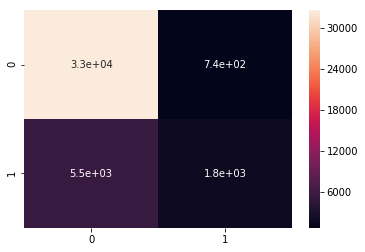

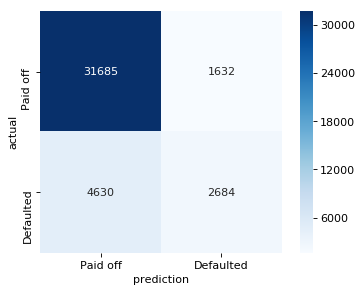

In [79]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.heatmap(cm, annot=True)
make_confusion_matrix(clf)



In [71]:
clf.predict_proba(X_test)[:,1]

array([0. , 0.1, 0.6, ..., 0.2, 0.1, 0.1])

f1_score:  0.4236510879110157
ROC AUC score =  0.7887144253596485


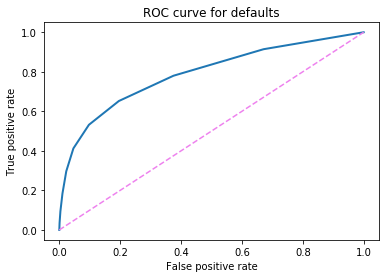

In [64]:


fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
print('f1_score: ', f1_score(y_test,predicted))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for defaults');
print("ROC AUC score = ", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic score: 0.8169


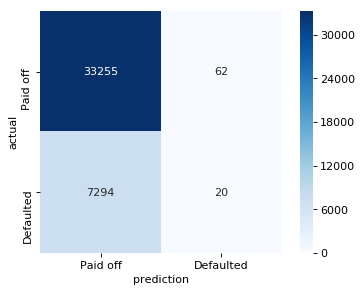

In [68]:
# Let's make a slightly better model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)
lm = LogisticRegression(C = 100)
lm.fit(X_train, y_train)
print("Logistic score: {:6.4f}".format(lm.score(X_train,y_train)))

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    mat_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(mat_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Paid off', 'Defaulted'],
           yticklabels=['Paid off', 'Defaulted']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
make_confusion_matrix(lm)

ROC AUC score =  0.6584121338405777


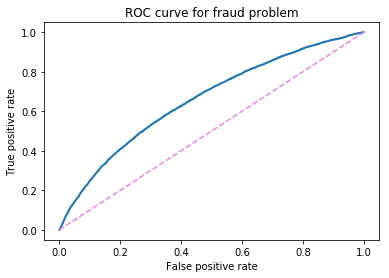

In [66]:

fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, lm.predict_proba(X_test)[:,1]))